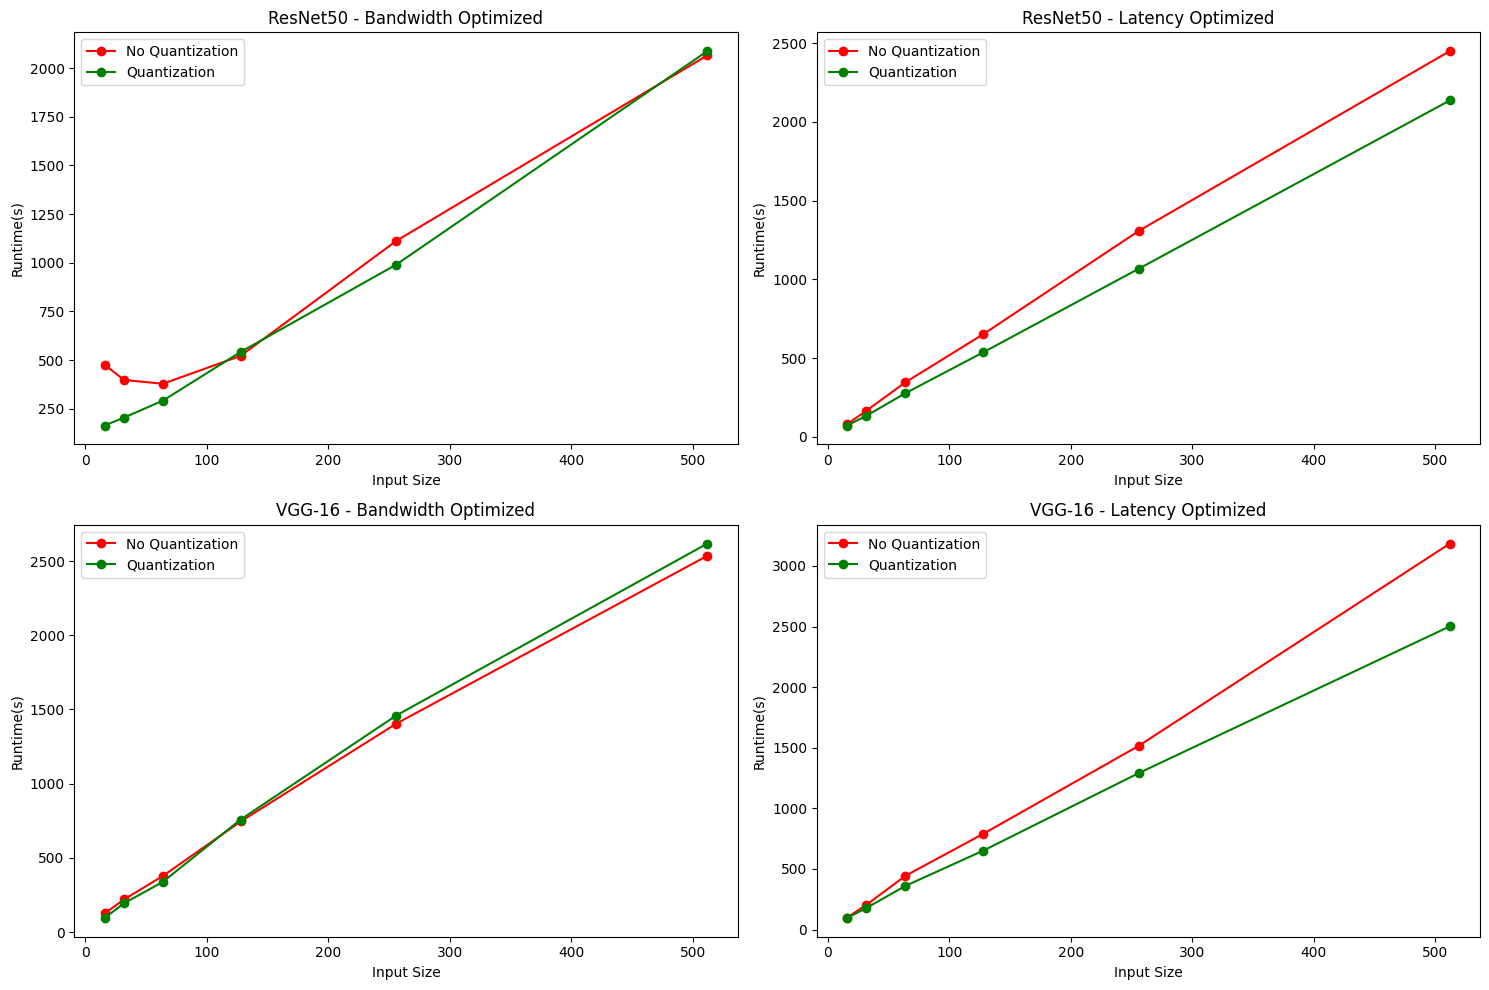

In [19]:
import pandas as pd
import matplotlib.pyplot as plt


def preprocess_runtime(value):
    if isinstance(value, str):
        # Remove all dots and convert the last three digits to milliseconds if necessary
        parts = value.split('.')
        if len(parts) > 1:
            # Combine all parts without dots and interpret the last three digits as milliseconds
            combined = ''.join(parts)
            milliseconds = int(combined) / 1000.0  # Convert to milliseconds
        else:
            milliseconds = float(value) * 1000  # Convert seconds to milliseconds
    else:
        milliseconds = value * 1000  # Assume float values are in seconds, convert to milliseconds
    
    return milliseconds

# Load the CSV file
df = pd.read_csv('Quantization_results.csv', sep=';')
# Apply the preprocessing to 'runtime_external(s)' column
df['runtime_chrono(s)'] = df['runtime_chrono(s)'].apply(preprocess_runtime)
df['input_size'] = df['input_size']*16
# Continue with your plotting code...





# Apply the preprocessing to 'runtime_external(s)' column
#df['runtime_external(s)'] = df['runtime_external(s)'].apply(preprocess_runtime)


# Mapping function codes to readable names
function_mapping = {
    71: "ResNet50 - Bandwidth Optimized - No Quantization",
    81: "ResNet50 - Latency Optimized - No Quantization",
    171: "ResNet50 - Bandwidth Optimized - Quantization",
    181: "ResNet50 - Latency Optimized - Quantization",
    74: "VGG-16 - Bandwidth Optimized - No Quantization",
    84: "VGG-16 - Latency Optimized - No Quantization",
    174: "VGG-16 - Bandwidth Optimized - Quantization",
    184: "VGG-16 - Latency Optimized - Quantization"
}

# Convert function codes to readable names
df['Configuration'] = df['function'].map(function_mapping)

# Splitting configurations for ResNet50 and VGG-16
configs = {
    'ResNet50 - Bandwidth Optimized': ['ResNet50 - Bandwidth Optimized - No Quantization', 'ResNet50 - Bandwidth Optimized - Quantization'],
    'ResNet50 - Latency Optimized': ['ResNet50 - Latency Optimized - No Quantization', 'ResNet50 - Latency Optimized - Quantization'],
    'VGG-16 - Bandwidth Optimized': ['VGG-16 - Bandwidth Optimized - No Quantization', 'VGG-16 - Bandwidth Optimized - Quantization'],
    'VGG-16 - Latency Optimized': ['VGG-16 - Latency Optimized - No Quantization', 'VGG-16 - Latency Optimized - Quantization']
}

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for i, (config_name, config_list) in enumerate(configs.items()):
    for config in config_list:
        # Ensure data is sorted by 'input_size'
        group = df[df['Configuration'] == config].sort_values(by='input_size')
        color = 'red' if 'No Quantization' in config else 'green'
        axs[i].plot(group['input_size'], group['runtime_chrono(s)'], 'o-', color=color, label=config.split(' - ')[2])
    axs[i].set_title(config_name)
    axs[i].set_xlabel('Input Size')
    axs[i].set_ylabel('Runtime(s)')
    axs[i].legend()

plt.tight_layout()
plt.show()


FIND THE CORRESPONDING runs


In [39]:

# Define the directory where your .loop and CSV files are located

import os
import csv
import json
from json.decoder import JSONDecodeError

# Define the directory where your .loop and CSV files are located
directory_path = '/Users/mervekilicarslan/Desktop/quantization_logs/meld'


# Define the values you want to match in the .loop files
loop_values_to_match = {
    "ssl": 0,
    "function": 181,
    "packbool": 1,
    "protocol": 5,
    "rxbuffer": 10000,
    "txbuffer": 10000,
    "input_size": 32
}

# Function to read values from a .loop file
def read_loop_file(loop_file):
    with open(loop_file, 'r') as f:
        loop_data = json.load(f)
    return loop_data

# Function to check if two dictionaries match based on specified values
def dictionaries_match(dict1, dict2):
    for key, value in loop_values_to_match.items():
        if key not in dict1 or dict1[key] != value:
            return False
    return True

def extract_run_number(loop_file):
    file_name = os.path.splitext(loop_file)[0]
    # Split the filename by underscores and extract the last part
    parts = file_name.split('_')
    run_number = parts[-1]
    return run_number


# Iterate through .loop files and find matching values
for loop_file in os.listdir(directory_path):
    if loop_file.endswith('.loop'):
        loop_path = os.path.join(directory_path, loop_file)
        loop_data = read_loop_file(loop_path)
        
        if dictionaries_match(loop_data, loop_values_to_match):
            print(f"Matching .loop file: {loop_file}")
            run_number = extract_run_number(loop_file)
            csv_file_name = f'testresults_{run_number}.csv'
            csv_file_path = os.path.join(directory_path, csv_file_name)
            break
    
if os.path.isfile(csv_file_path):
    print(f"Corresponding CSV file: {csv_file_name}")
            # Now you can proceed to plot values from the CSV file
            # You can add your code to plot values here
else:
    print(f"CSV file not found for .loop file: {loop_file}")

Matching .loop file: 2024-01-26_03-48-09_746573_unknown_run47.loop
Corresponding CSV file: testresults_run47.csv


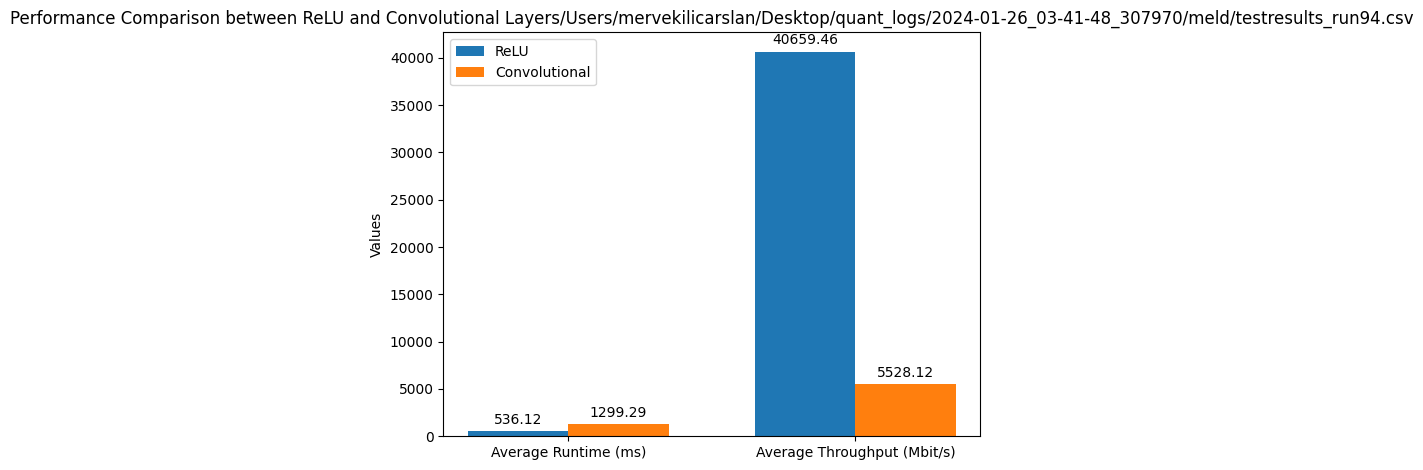

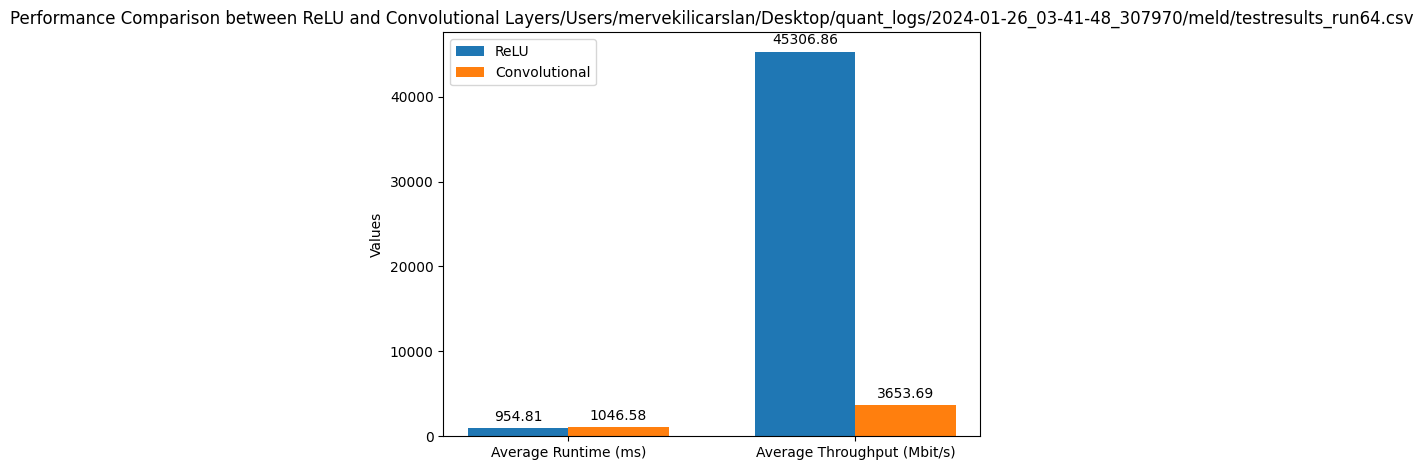

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_layer_performance(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)
    
    # Remove leading spaces from column names if they exist
    data.columns = data.columns.str.strip()
    
    # Filter data for ReLU (ACTIVATION) and Convolutional layers (CONV2D)
    relu_data = data[data['LayerType'] == 'ACTIVATION']
    conv_data = data[data['LayerType'] == 'CONV2D']
    
    # Compute average performance metrics for ReLU and Convolutional layers
    relu_performance = relu_data[['MS Live', 'Mbit/s']].mean()
    conv_performance = conv_data[['MS Live', 'Mbit/s']].mean()
    
    # Prepare the data for plotting
    metrics = ['Average Runtime (ms)', 'Average Throughput (Mbit/s)']
    relu_values = [relu_performance['MS Live'], relu_performance['Mbit/s']]
    conv_values = [conv_performance['MS Live'], conv_performance['Mbit/s']]
    
    # Plotting
    x = list(range(len(metrics)))  # Convert range to list for arithmetic operations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar([xi - width/2 for xi in x], relu_values, width, label='ReLU')
    rects2 = ax.bar([xi + width/2 for xi in x], conv_values, width, label='Convolutional')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Values')
    ax.set_title('Performance Comparison between ReLU and Convolutional Layers'+file_path)
    
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Function to auto-label the bars
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

# Usage example: plot_layer_performance('/path/to/your/csvfile.csv')
# Replace '/path/to/your/csvfile.csv' with the actual path to your CSV file


csv_path = os.path.join(directory_path, csv_file_name)
plot_layer_performance(csv_path)
csv_file_name = 'testresults_run64.csv'
csv_path = os.path.join(directory_path, csv_file_name)
plot_layer_performance(csv_path)

In [ ]:
for the bandwitdh check the total communication for th conv layer because we have an extra multoplication that is why. TOTAL COMM HIGHER WITH QUNATIZATION. 
2 operation s with 8 bit another 32 bit operation.

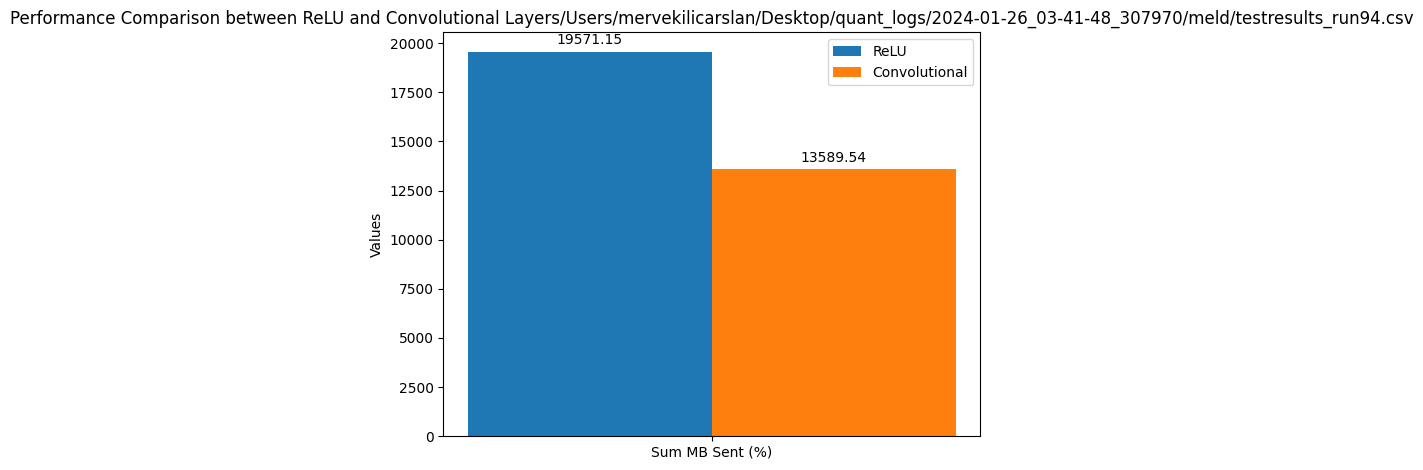

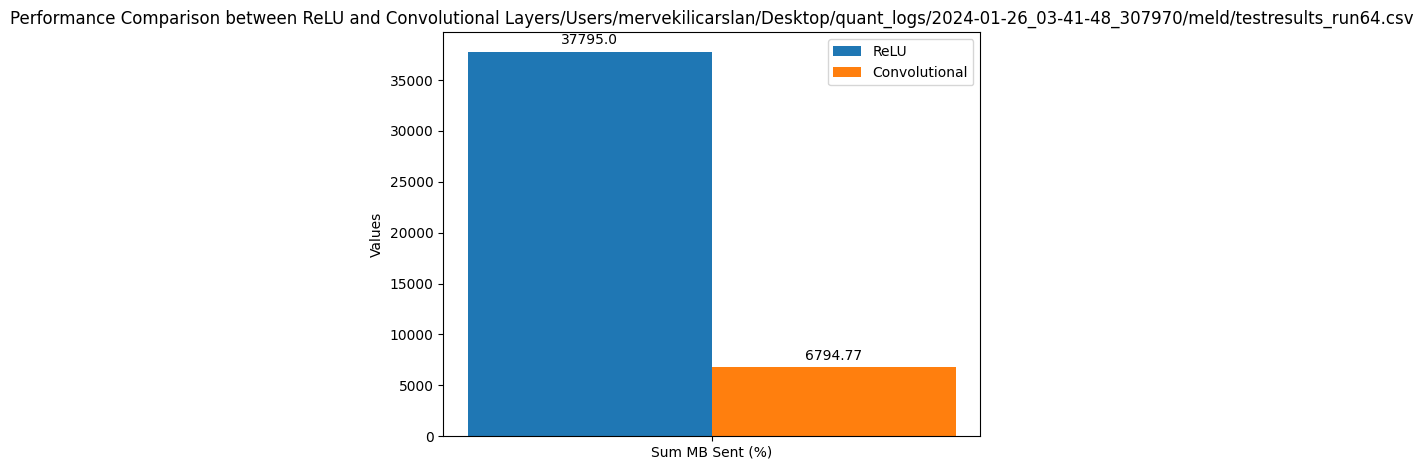

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_layer_performance(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)
    
    # Remove leading spaces from column names if they exist
    data.columns = data.columns.str.strip()
    
    # Filter data for ReLU (ACTIVATION) and Convolutional layers (CONV2D)
    relu_data = data[data['LayerType'] == 'ACTIVATION']
    conv_data = data[data['LayerType'] == 'CONV2D']
    
    # Compute average performance metrics for ReLU and Convolutional layers
    relu_performance = relu_data[['MB Sent']].sum()
    conv_performance = conv_data[['MB Sent']].sum()
    
    # Prepare the data for plotting
    metrics = ['Sum MB Sent (%)']
    relu_values = [relu_performance['MB Sent']]
    conv_values = [conv_performance['MB Sent']]
    
    # Plotting
    x = list(range(len(metrics)))  # Convert range to list for arithmetic operations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar([xi - width/2 for xi in x], relu_values, width, label='ReLU')
    rects2 = ax.bar([xi + width/2 for xi in x], conv_values, width, label='Convolutional')
  

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Values')
    ax.set_title('Performance Comparison between ReLU and Convolutional Layers'+file_path)
    
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Function to auto-label the bars
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

# Usage example: plot_layer_performance('/path/to/your/csvfile.csv')
# Replace '/path/to/your/csvfile.csv' with the actual path to your CSV file


csv_path = os.path.join(directory_path, csv_file_name)
plot_layer_performance(csv_path)
csv_file_name = 'testresults_run64.csv'
csv_path = os.path.join(directory_path, csv_file_name)
plot_layer_performance(csv_path)

<Figure size 1000x600 with 0 Axes>

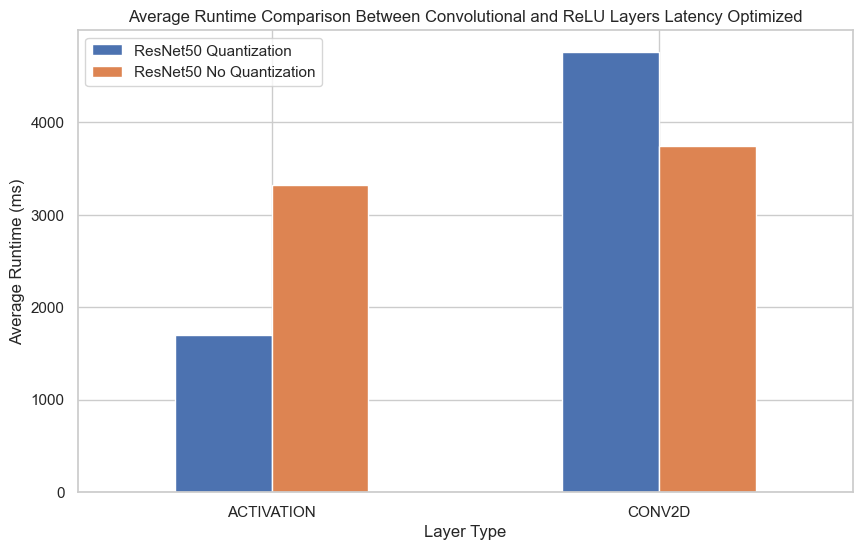

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the log files
file1 = 'testresults_run95.csv'  # Update this path to your actual file location
file2 = 'testresults_run65.csv'  # Update this path to your actual file location
file1_path =  os.path.join(directory_path, file1) # Update this path to your actual file location
file2_path = os.path.join(directory_path, file2)  # Update this path to your actual file location

df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Filter the DataFrame for only CONV2D and ACTIVATION layers
conv_relu_df1 = df1[df1['LayerType'].isin(['CONV2D', 'ACTIVATION'])]
conv_relu_df2 = df2[df2['LayerType'].isin(['CONV2D', 'ACTIVATION'])]

# Group by LayerType and calculate the average runtime
avg_runtime_df1 = conv_relu_df1.groupby('LayerType')['MS Live'].mean().reset_index()
avg_runtime_df2 = conv_relu_df2.groupby('LayerType')['MS Live'].mean().reset_index()

# Prepare data for plotting
avg_runtime_df = pd.merge(avg_runtime_df1, avg_runtime_df2, on='LayerType', suffixes=('_File1', '_File2'))
avg_runtime_df.set_index('LayerType', inplace=True)

# Plot
plt.figure(figsize=(10, 6))
avg_runtime_df.plot(kind='bar', figsize=(10, 6))
plt.title('Average Runtime Comparison Between Convolutional and ReLU Layers Latency Optimized')
plt.ylabel('Average Runtime (ms)')
plt.xlabel('Layer Type')
plt.xticks(rotation=0)
plt.legend(['ResNet50 Quantization', 'ResNet50 No Quantization'])
plt.show()


In [ ]:
95-65 vgg16 latency
53-83 vgg16 bandwidth
35-05  restnet 50  bandwidth
47-17 restnet 50 latency

<Figure size 1000x600 with 0 Axes>

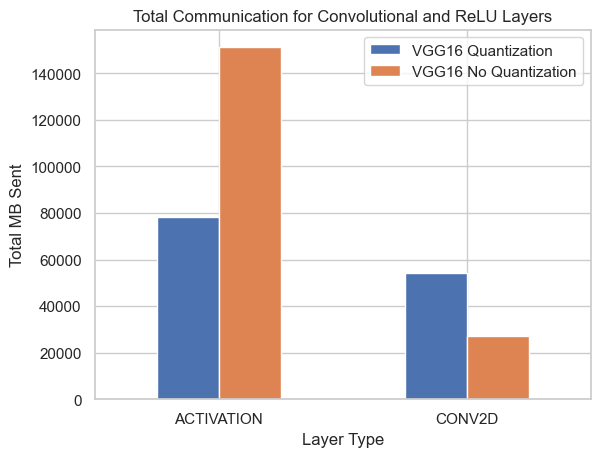

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# Filter for CONV2D and ACTIVATION layers
conv_relu_df1 = df1[df1['LayerType'].isin(['CONV2D', 'ACTIVATION'])]
conv_relu_df2 = df2[df2['LayerType'].isin(['CONV2D', 'ACTIVATION'])]

# Sum the 'MB Sent' for each layer type to get the total communication
total_comm_df1 = conv_relu_df1.groupby('LayerType')['MB Sent'].sum().reset_index()
total_comm_df2 = conv_relu_df2.groupby('LayerType')['MB Sent'].sum().reset_index()

# Merge the two DataFrames for comparison
total_comm_comparison_df = pd.merge(total_comm_df1, total_comm_df2, on='LayerType', suffixes=('_File1', '_File2'))

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
total_comm_comparison_df.set_index('LayerType').plot(kind='bar')
plt.title('Total Communication for Convolutional and ReLU Layers')
plt.ylabel('Total MB Sent')
plt.xlabel('Layer Type')
plt.xticks(rotation=0)
plt.legend(['VGG16 Quantization', 'VGG16 No Quantization'])
plt.show()


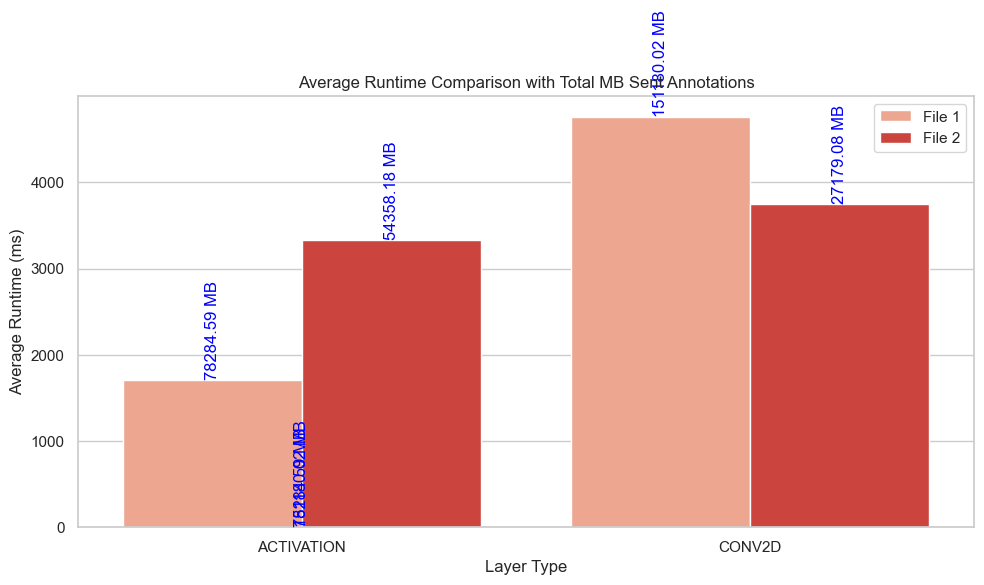

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_runtime_with_communication(df, ax):
    sns.barplot(x='LayerType', y='MS Live', hue='File', data=df, palette='Reds', ax=ax)
    ax.set_title('Average Runtime Comparison with Total MB Sent Annotations')
    ax.set_xlabel('Layer Type')
    ax.set_ylabel('Average Runtime (ms)')
    ax.legend(title=None)

    # Iterate over the bars and use the index to access the corresponding total MB sent value
    for index, p in enumerate(ax.patches):
        height = p.get_height()
        # Calculate the index of the data point in the DataFrame corresponding to this bar
        data_index = index // 2  # There are two bars (File 1 and File 2) for each layer type
        layer_type = df.iloc[data_index]['LayerType']
        file = 'File 1' if index % 2 == 0 else 'File 2'
        total_mb_sent = df[(df['LayerType'] == layer_type) & (df['File'] == file)]['MB Sent'].values[0]
        ax.text(p.get_x() + p.get_width() / 2., height + 5,
                f'{total_mb_sent:.2f} MB', ha='center', va='bottom', rotation=90, color='blue')


df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# Filter for CONV2D and ACTIVATION layers
conv_relu_df1 = df1[df1['LayerType'].isin(['CONV2D', 'ACTIVATION'])]
conv_relu_df2 = df2[df2['LayerType'].isin(['CONV2D', 'ACTIVATION'])]

# Calculate average runtime and total communication
metrics_df1 = conv_relu_df1.groupby('LayerType').agg({'MS Live': 'mean', 'MB Sent': 'sum'}).reset_index()
metrics_df2 = conv_relu_df2.groupby('LayerType').agg({'MS Live': 'mean', 'MB Sent': 'sum'}).reset_index()
metrics_df1['File'] = 'File 1'
metrics_df2['File'] = 'File 2'
final_df = pd.concat([metrics_df1, metrics_df2]).reset_index(drop=True)

# Plotting
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot average runtime comparison with total MB sent annotations
plot_runtime_with_communication(final_df, ax)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV files
file1 = 'file1.csv'
file2 = 'file2.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Extract the continuous values from each DataFrame
x1 = df1['x']
y1 = df1['y']
z1 = df1['z']
w1 = df1['w']

x2 = df2['x']
y2 = df2['y']
z2 = df2['z']
w2 = df2['w']

# Extract the layer types and corresponding average bandwidth and summed up MB sent values
layer_types1 = df1['LayerType']
avg_bandwidth1 = df1.groupby('LayerType')['Bandwidth'].mean()
sum_mb_sent1 = df1.groupby('LayerType')['MB Sent'].sum()

layer_types2 = df2['LayerType']
avg_bandwidth2 = df2.groupby('LayerType')['Bandwidth'].mean()
sum_mb_sent2 = df2.groupby('LayerType')['MB Sent'].sum()

# Plot the continuous values
plt.plot(x1, y1, label='File 1 - Layer 1')
plt.plot(x1, z1, label='File 1 - Layer 2')
plt.plot(x2, y2, label='File 2 - Layer 1')
plt.plot(x2, z2, label='File 2 - Layer 2')

# Plot the average bandwidth values
plt.scatter(x1, avg_bandwidth1['Layer 1'], label='File 1 - Layer 1 Average Bandwidth')
plt.scatter(x1, avg_bandwidth1['Layer 2'], label='File 1 - Layer 2 Average Bandwidth')
plt.scatter(x2, avg_bandwidth2['Layer 1'], label='File 2 - Layer 1 Average Bandwidth')
plt.scatter(x2, avg_bandwidth2['Layer 2'], label='File 2 - Layer 2 Average Bandwidth')

# Plot the summed up MB sent values
plt.scatter(x1, sum_mb_sent1['Layer 1'], label='File 1 - Layer 1 Summed MB Sent')
plt.scatter(x1, sum_mb_sent1['Layer 2'], label='File 1 - Layer 2 Summed MB Sent')
plt.scatter(x2, sum_mb_sent2['Layer 1'], label='File 2 - Layer 1 Summed MB Sent')
plt.scatter(x2, sum_mb_sent2['Layer 2'], label='File 2 - Layer 2 Summed MB Sent')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y / Z / Average Bandwidth / Summed MB Sent')
plt.title('Comparison of Continuous Values, Average Bandwidth, and Summed MB Sent')

# Add legend
plt.legend()

# Show the plot
plt.show()
